<a href="https://colab.research.google.com/github/OH1107/aisa_edu/blob/master/ML/ML_2%EC%9D%BC%EC%B0%A8_20200819_%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## I. 사전 준비작업
- `Kaggle API` 설치 및 연동해서 `GCP`에 데이터를 적재하는 것까지 진행한다. 

### (1) Kaggle API 설치
- 구글 코랩에서 `API`를 불러오려면 다음 소스코드를 실행

In [1]:
!pip install kaggle

### (2) Kaggle Token 다운로드
- Kaggle에서 API Token을 다운로드
- [Kaggle]-[My Account]-[API]-[Create New API Token]을 누르면 `kaggle.json` 
- 이 파일을 바탕화면에 옮긴 뒤, 아래 코드를 실행


In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [3]:
# kaggle.json을 아래 폴더로 옮긴 뒤, file을 사용할 수 있도록 권한을 부여한다. 
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


### (3-1) Kaggle 데이터 불러오기
- `Kaggle` 대회 리스트를 불러온다. 

In [4]:
!kaggle competitions list

401 - Unauthorized


- 타이타닉데이터를 다운


In [5]:
!kaggle competitions download -c titanic

401 - Unauthorized


### (3-2)구글드라이브 코랩 연동 과정
- kaggle 데이터가 뜨지 않으므로 구글드라이브와 연동해서 데이터를 불러올 것

#### (1) Mount Google Drive to Google Colab
- 구글 드라이브(Drive)를 구글 코랩(Colab)에 mount하기 위해 아래 코드를 작성
- 이 때 authorization code가 활성화 되는데, 인증을 진행

In [6]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# 현재 경로 확인
%pwd

'/content'

In [8]:
# 현재 경로의 파일 확인
%ls

adc.json  c:Ohhhhh/  drive/  sample_data/


In [9]:
# 경로 이동
%cd drive/'My Drive'/'Colab Notebooks'/'ML_Project'/'titanic'

/content/drive/My Drive/Colab Notebooks/ML_Project/titanic


### (4) BigQuery에 데이터 적재
- `sample_submission.csv`, `test.csv`, `train.csv` 데이터를 불러와서 빅쿼리에 적재
- 로컬에서 빅쿼리로 데이터를 Load하는 방법에는 여러가지가 있다.
  + `Local`에서 직접 올리기 (단, 10MB 이하)
  + `Google Stroage` 활용
  + `Pandas` 활용
- `Pandas`패키지를 활용
  + `to_gbq`라는 함수를 사용하는데, 이를 위해서는 보통 `pandas-gbq package`패키지를 별도로 설치 `Colab`은 본 패키지가 설치 되어 있음

In [10]:
import pandas as pd
from pandas.io import gbq

# import sample_submission file
gender_submission = pd.read_csv('gender_submission.csv')

# Connect to Google Cloud API and Upload DataFrame
gender_submission.to_gbq(destination_table='titanic.gender_submission', 
                  project_id='groovy-ego-286903',
                  if_exists='replace')

1it [00:05,  5.29s/it]


In [11]:
# test.csv 파일 임포트

test = pd.read_csv('test.csv')

test.to_gbq(destination_table='titanic.test', 
                  project_id='groovy-ego-286903',
                  if_exists='replace')

1it [00:02,  2.80s/it]


In [12]:
# train.csv 파일 임포트

train = pd.read_csv('train.csv')

train.to_gbq(destination_table='titanic.train', 
                  project_id='groovy-ego-286903',
                  if_exists='replace')

1it [00:03,  3.31s/it]


- 임포트가 정상적으로 되었는지 확인

In [13]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## II. 데이터 피처공학
- 사이킷런 패키지는 기본적으로 결측치를 허용하지 않기 때문에, 반드시 확인 후, 처리해야함 
- `BigQuery`를 통해 데이터 사용
- 주요 데이터 추출을 위한 피처공학을 다룰 것임

### (1) 주요 패키지 불러오기
- 이제 주요 패키지 호출

In [14]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## (2) 데이터 불러오기

In [15]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [16]:
# 구글 인증 라이브러리
from google.colab import auth

# 빅쿼리 관련 라이브러리
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

- 먼저 훈련 데이터를 불러온다.

In [17]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

project_id = 'groovy-ego-286903'
client = bigquery.Client(project=project_id)

df_train = client.query('''
  SELECT 
      * 
  FROM `groovy-ego-286903.titanic.train`
  ''').to_dataframe()

df_train.shape

(891, 12)

- 그 다음은 테스트 데이터를 불러온다. 

In [18]:
df_test = client.query('''
  SELECT 
      * 
  FROM `groovy-ego-286903.titanic.test`
  ''').to_dataframe() # 빅쿼리안의 쿼리문을 여기서 이렇게 써서 전체를 데이터프레임으로가꼬와라

df_test.shape

(418, 11)

- 아래 코드는 출력 시, 전체 `Column`에 대해 확인할 수 있음

In [19]:
pd.options.display.max_columns = None  # 칼럼이 길어지면 ... 나오는걸로 짤리는거 방지하는 거
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,None,S
1,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
2,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,None,S
3,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,None,S
4,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,None,S


- 각 데이터에 대한 설명은 다음을 참조한다. 
  + 참조: https://www.kaggle.com/c/titanic/data

### (3) 결측 데이터 확인

In [20]:
# data set의 Percent 구하는 함수를 짜보자. 
def check_fill_na(data):
  new_df = data.copy()
  new_df_na = (new_df.isnull().sum() / len(new_df)) * 100
  new_df_na.sort_values(ascending=False).reset_index(drop=True)
  new_df_na = new_df_na.drop(new_df_na[new_df_na == 0].index).sort_values(ascending=False)
  return new_df_na

check_fill_na(df_train)

Cabin       77.104377
Age         19.865320
Embarked     0.224467
dtype: float64

- 결측치에 대한 보간을 진행한다. 
  + `Age`는 중간값 
  + `Embarked`는 `S`로 채웠다. 
  + `Cabin`은 삭제하기로 했다. 

In [21]:
train_data = df_train.copy()
train_data["Age"].fillna(df_train["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(df_train['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

- 위 데이터에 결측치가 없도록 처리하였다. 

In [22]:
check_fill_na(train_data)

Series([], dtype: float64)

### (4) 도출변수
- `SilSp` + `Parch` 변수를 조합하여 혼자 여행을 온 것인지 아닌지 구분하는 도출 변수를 만든 후, 위 변수는 삭제 한다. 

In [23]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

- `Age`별 생존여부에 관한 그래프를 작성한다. 

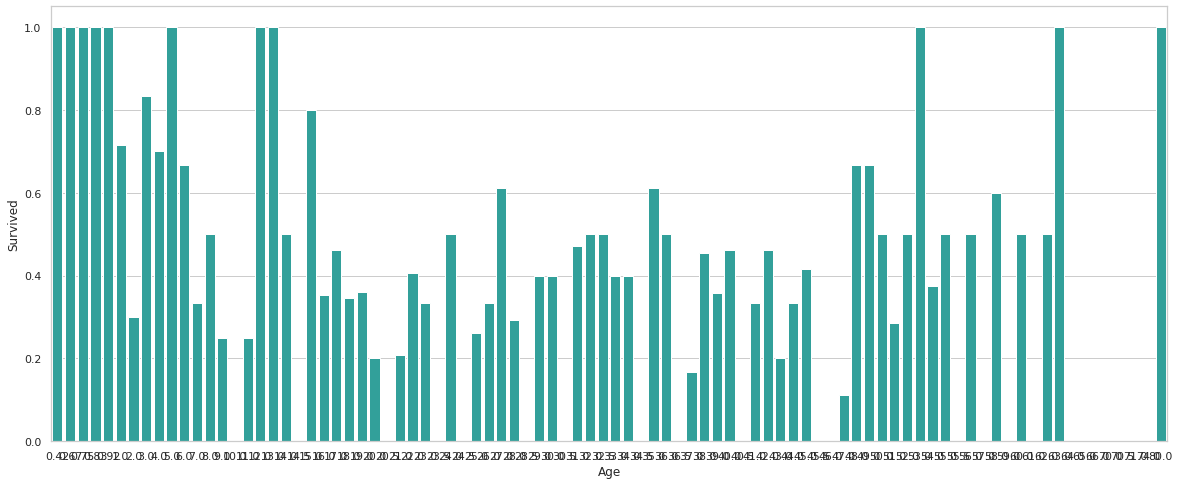

In [24]:
plt.figure(figsize=(20,8))
avg_survival_byage = train_data[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()
g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

- 그 후에 `under_age`에 대한 도출변수를 추가로 만든다. 

In [25]:
train_data['IsMinor']=np.where(train_data['Age']<=16, 1, 0)

### (5) 원-핫 인코딩
- 각 `Column` 특히, `문자형 변수`에 대해 원-핫 인코딩을 진행한다. 

In [26]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Age          891 non-null    float64
 2   Fare         891 non-null    float64
 3   TravelAlone  891 non-null    int64  
 4   IsMinor      891 non-null    int64  
 5   Pclass_1     891 non-null    uint8  
 6   Pclass_2     891 non-null    uint8  
 7   Pclass_3     891 non-null    uint8  
 8   Embarked_C   891 non-null    uint8  
 9   Embarked_Q   891 non-null    uint8  
 10  Embarked_S   891 non-null    uint8  
 11  Sex_male     891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(7)
memory usage: 41.0 KB


- 위에 했던 작업을 동일하게 `test` 데이터에도 적용한다. 

In [27]:
test_data = df_test.copy()
test_data["Age"].fillna(df_test["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(df_test["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

test_data['IsMinor']=np.where(test_data['Age']<=16, 1, 0)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          418 non-null    float64
 1   Fare         418 non-null    float64
 2   TravelAlone  418 non-null    int64  
 3   IsMinor      418 non-null    int64  
 4   Pclass_1     418 non-null    uint8  
 5   Pclass_2     418 non-null    uint8  
 6   Pclass_3     418 non-null    uint8  
 7   Embarked_C   418 non-null    uint8  
 8   Embarked_Q   418 non-null    uint8  
 9   Embarked_S   418 non-null    uint8  
 10  Sex_male     418 non-null    uint8  
dtypes: float64(2), int64(2), uint8(7)
memory usage: 16.0 KB


### (6) 피처 선택 (Feature Selection)
- Feature Selection을 통해 학습을 진행한다.
  + 방법론: Recursive Feature Elimination (RFE)
  + 참조: http://scikit-learn.org/stable/modules/feature_selection.html
  + 목적, Backward 방식 중 하나로, 모든 변수를 우선 다 포함시킨 후 반복해서 학습을 진행하면서 중요도가 낮은 변수를 하나씩 제거하는 방식.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train[cols]
y = final_train['Survived']
model = LogisticRegression()
rfe = RFE(model, 8) # 변수 8개만 선택
rfe = rfe.fit(X, y)
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


- 이번에는 변수의 갯수에 따라 `classification` 정확도를 시각화 하여 변수의 개수를 정해본다. 

Optimal number of features: 8
Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


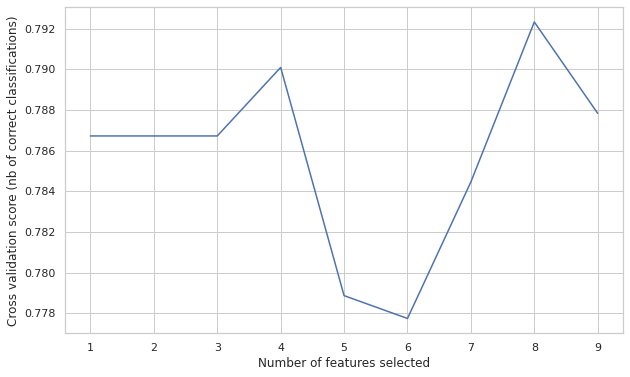

In [29]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

- 해당 주요 변수를 `Selected_features`로 저장한다.

In [30]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']

## III. 머신러닝
- 로지스틱 회귀모형을 통해 머신러닝을 수행한다. 


### (1) 머신러닝 모형 개발
- 데이터셋 분리 부터 모형 개발까지 진행해본다. 

Train/Test split results:
LogisticRegression accuracy is 0.799
LogisticRegression log_loss is 0.460
LogisticRegression auc is 0.852


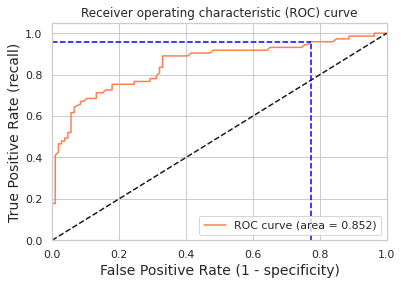

Using a threshold of 0.086 guarantees a sensitivity of 0.959 and a specificity of 0.226, i.e. a false positive rate of 77.36%.


In [31]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# 데이터 셋 분리 
X = final_train[Selected_features]
y = final_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# 로지스틱 회귀모형
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # threshold 

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

- Using a threshold of 0.086 guarantees a sensitivity of 0.959 and a specificity of 0.226, i.e. a false positive rate of 77.36%.

- Using a threshold of 0.672 guarantees a sensitivity of 0.521 and a specificity of 0.953, i.e. a false positive rate of 4.72%.

### (2) 예측 테이블 생성
- 예측 테이블을 만들어 제출한다. 

In [32]:
final_test['Survived'] = logreg.predict(final_test[Selected_features])
final_test['PassengerId'] = df_test['PassengerId']
submission = final_test[['PassengerId','Survived']]
submission.to_csv("submission.csv", index=False)
print(submission.tail())

     PassengerId  Survived
413         1043         0
414         1101         0
415         1157         0
416         1187         0
417         1226         0
